# Tutorial 1: Simple quantum circuits

## Prerequisite: installation of myqlm

    pip install myqlm

    pip install myqlm-simulators

## Documentation

You will find code examples on https://myqlm.github.io.

## 1. Bell state circuit

Our aim is to prepare the Bell state $$\frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

### Solution

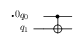

In [1]:
from qat.lang.AQASM import H, CNOT, Program

prog = Program()
reg = prog.qalloc(2)

prog.apply(H, reg[0])
prog.apply(CNOT, reg)

circ = prog.to_circ()

%qatdisplay circ

We now execute this circuit on a Quantum Processing Unit (QPU):

In [2]:
from qat.qpus import get_default_qpu
qpu = get_default_qpu()

job = circ.to_job(nbshots=10, aggregate_data=False)
res = qpu.submit(job)

The number of shots is the number of independent final $Z$-axis measurements on the quantum state. Thus, we expect to see the 10 outcomes of measuring both qubits on the $Z$ axis. 

We print the results:

In [3]:
for sample in res:
    print(sample.state)

|00>
|00>
|11>
|00>
|11>
|11>
|00>
|00>
|11>
|00>


We can tell the QPU to aggregate the data, i.e collect the statistics of the outcomes to compute the histogram of the shots, and hence the estimated probability (``sample.probability``) (with its statistical error ``sample.err``) of a computational state in the final distribution:

In [4]:
job = circ.to_job(nbshots=10)
res = qpu.submit(job)
for sample in res:
    print(sample.state, sample.probability, sample.err)

|00> 0.5 0.16666666666666666
|11> 0.5 0.16666666666666666


Finally, since we are performing classical simulation, we have access to the exact probabilities, and to the probability amplitudes of the states (because we are doing pure-state simulations at this stage). This is achieved by choosing an infinite number of shots, which we choose, by convention, by setting ``nbshots=0``:

In [5]:
job = circ.to_job(nbshots=0)
res = qpu.submit(job)
for sample in res:
    print(sample.state, sample.probability, sample.amplitude)

|00> 0.4999999999999999 (0.7071067811865475+0j)
|11> 0.4999999999999999 (0.7071067811865475+0j)


## 2. Teleportation

Alice wants to send a qubit in state $|\psi\rangle$ to Bob with the help of a shared entangled pair between Alice and Bob.



### Solution
We suppose Alice has a state $\cos(\alpha/2) |0\rangle - i \sin(\alpha/2) |1\rangle$, and teleport it to Bob.

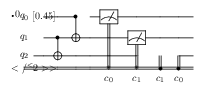

In [6]:
from qat.lang.AQASM import RX, X, Z

alpha = 0.45

prog = Program()
reg = prog.qalloc(3) # 1 qubit for |psi>, 2 qubits for Bell state
creg = prog.calloc(2) # 2 classical bits
# prepare state on Alice's side (unknown to Bob)
prog.apply(RX(alpha), reg[0])

# prepare Bell state
prog.apply(H, reg[1])
prog.apply(CNOT, reg[1], reg[2])

# teleportation circuit
CNOT(reg[0], reg[1]) # equivalent to prog.apply(CNOT, reg[0], reg[1])
H(reg[0])
prog.measure(reg[0], creg[0])
prog.measure(reg[1], creg[1])
prog.cc_apply(creg[1], X, reg[2])
prog.cc_apply(creg[0], Z, reg[2])

circ = prog.to_circ()

%qatdisplay circ

Let us now execute the circuit, supposing we have infinite statistics (infinite number of shots):

In [7]:
qpu = get_default_qpu()
job = circ.to_job(nbshots=0)
res = qpu.submit(job)

for sample in res:
    print(sample.state, sample.amplitude, sample.probability)

|110> (0.9747941070689433+0j) 0.9502235511763385
|111> (-0-0.22310636213174545j) 0.04977644882366154


In [8]:
import numpy as np
# Expected result
# RX(alpha) |0> = cos(alpha/2) - i sin(alpha/2)
print("Expecting: %s |0> - i %s |1>"%(np.cos(alpha/2), np.sin(alpha/2)))

Expecting: 0.9747941070689433 |0> - i 0.22310636213174545 |1>
